Motivated by [issue#6](https://github.com/phylsix/FireHydrant/issues/6), here signal reconstruction efficiencies are plotted for each parameter. The numberator and denominators are describled in the issue.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib
import matplotlib.pyplot as plt
from awkward import JaggedArray
from FireHydrant.Tools.plotting import heatmap, annotate_heatmap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [3]:
dataset = {}
dataset.update({f'4mu/{k}': dict(files=v, treename='ffNtuplizer/ffNtuple') for k,v in dataset4mu_.items()})
dataset.update({f'2mu2e/{k}': dict(files=v, treename='ffNtuplizer/ffNtuple') for k,v in dataset2mu2e_.items()})

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Selected datasets')
        
        self._accumulator = processor.dict_accumulator({
            'counts': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        
        output['counts'][dataset+'__denom'] += darkphotons.size
        
        ## two leptonJets
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        darkphotons = darkphotons[twoleptonjets]
        
        ## ensure both darkphotons are well-reconstructed
        mask_ = darkphotons.match(dileptonjets, deltaRCut=0.3).all()
        dileptonjets = dileptonjets[mask_]
        darkphotons = darkphotons[mask_]
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:,1],1)]
        
        leadmask = leadlj.match(darkphotons, deltaRCut=0.3)
        sublmask = subllj.match(darkphotons, deltaRCut=0.3)
        
        output['counts'][dataset+'__numer'] += (leadmask&sublmask).flatten().astype(int).sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 320/320 [00:38<00:00,  7.71items/s]


In [6]:
params=set([x.split('__')[0] for x in output['counts'].keys()])
datapoints = {k: output['counts'][k+'__numer']/output['counts'][k+'__denom'] for k in params}

mdp = [5, 2.5, 1.2, 0.8, 0.25]
mxx = [100, 200, 500, 800, 1000]

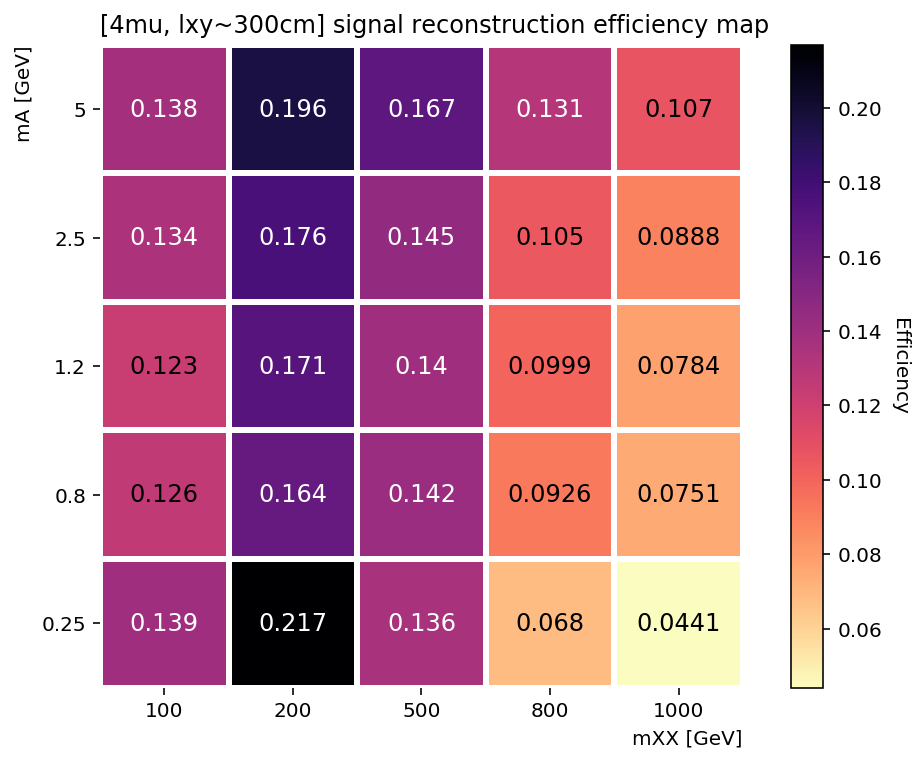

In [7]:
d = []
for my in mdp:
    row = []
    for mx in mxx:
        k = f'4mu/mXX-{str(mx)}_mA-{str(my).replace(".", "p")}_lxy-300'
        row.append(datapoints.get(k, None))
    d.append(row)
d = np.array(d)

fig, ax = plt.subplots(figsize=(7,5))
im, cbar = heatmap(d, mdp, mxx, ax=ax, cmap="magma_r", cbarlabel="Efficiency")
texts = annotate_heatmap(im, valfmt="{x:.3g}", fontsize=12)
fig.tight_layout()
ax.set_title('[4mu, lxy~300cm] signal reconstruction efficiency map', x=0.0, ha="left")
ax.set_xlabel('mXX [GeV]', x=1.0, ha="right")
ax.set_ylabel('mA [GeV]', y=1.0, ha="right");

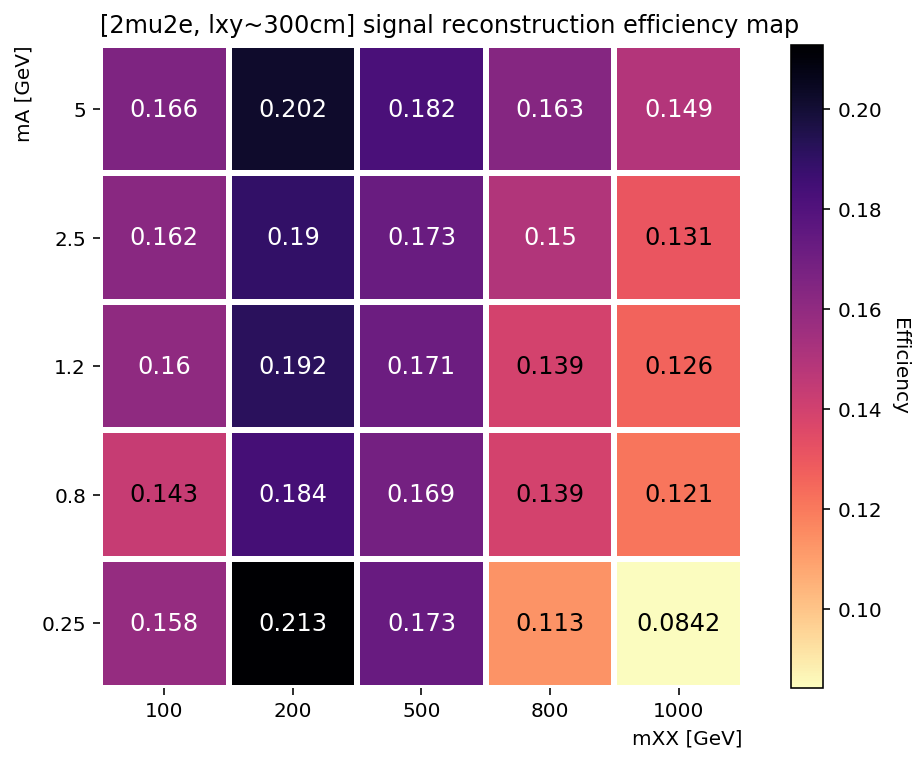

In [8]:
d = []
for my in mdp:
    row = []
    for mx in mxx:
        k = f'2mu2e/mXX-{str(mx)}_mA-{str(my).replace(".", "p")}_lxy-300'
        row.append(datapoints.get(k, None))
    d.append(row)
d = np.array(d)

fig, ax = plt.subplots(figsize=(7,5))
im, cbar = heatmap(d, mdp, mxx, ax=ax, cmap="magma_r", cbarlabel="Efficiency")
texts = annotate_heatmap(im, valfmt="{x:.3g}", fontsize=12)
fig.tight_layout()
ax.set_title('[2mu2e, lxy~300cm] signal reconstruction efficiency map', x=0.0, ha="left")
ax.set_xlabel('mXX [GeV]', x=1.0, ha="right")
ax.set_ylabel('mA [GeV]', y=1.0, ha="right");

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/matplotlib/colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


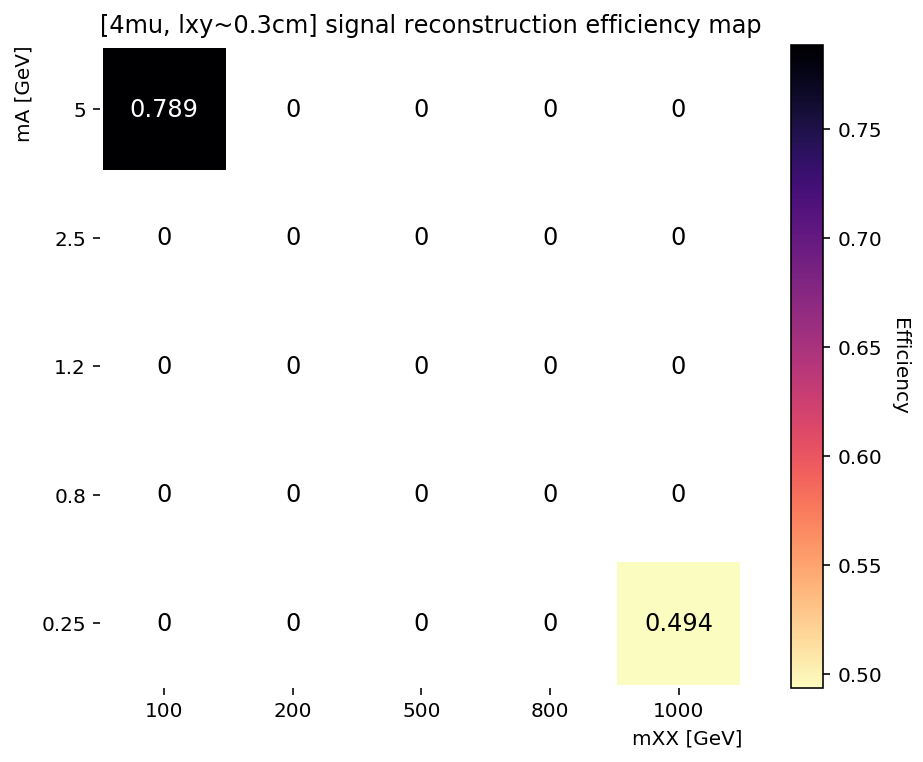

In [9]:
d = []
for my in mdp:
    row = []
    for mx in mxx:
        k = f'4mu/mXX-{str(mx)}_mA-{str(my).replace(".", "p")}_lxy-0p3'
        row.append(datapoints.get(k, np.nan))
    d.append(row)
d = np.array(d)

fig, ax = plt.subplots(figsize=(7,5))
im, cbar = heatmap(d, mdp, mxx, ax=ax, cmap="magma_r", cbarlabel="Efficiency")
texts = annotate_heatmap(im, valfmt="{x:.3g}", fontsize=12)
fig.tight_layout()
ax.set_title('[4mu, lxy~0.3cm] signal reconstruction efficiency map', x=0.0, ha="left")
ax.set_xlabel('mXX [GeV]', x=1.0, ha="right")
ax.set_ylabel('mA [GeV]', y=1.0, ha="right");

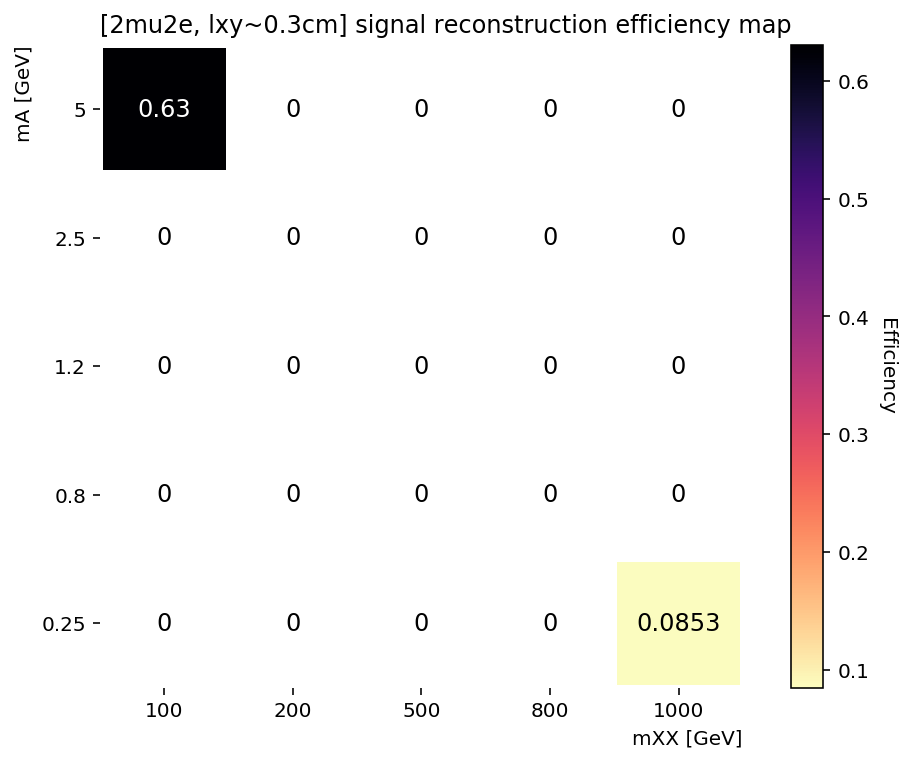

In [10]:
d = []
for my in mdp:
    row = []
    for mx in mxx:
        k = f'2mu2e/mXX-{str(mx)}_mA-{str(my).replace(".", "p")}_lxy-0p3'
        row.append(datapoints.get(k, np.nan))
    d.append(row)
d = np.array(d)

fig, ax = plt.subplots(figsize=(7,5))
im, cbar = heatmap(d, mdp, mxx, ax=ax, cmap="magma_r", cbarlabel="Efficiency")
texts = annotate_heatmap(im, valfmt="{x:.3g}", fontsize=12)
fig.tight_layout()
ax.set_title('[2mu2e, lxy~0.3cm] signal reconstruction efficiency map', x=0.0, ha="left")
ax.set_xlabel('mXX [GeV]', x=1.0, ha="right")
ax.set_ylabel('mA [GeV]', y=1.0, ha="right");